In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore')

import logging

logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled = True

def stationary_test(series):
    result = adfuller(series)
    return (result[0], result[1])

data = pd.read_csv('variable_selected_county_dataset.csv').iloc[:, 1:]

col = ['date', 'incremental_cases', 'stay_at_home_announced', 'stay_at_home_effective', 'mean_temp',
       'min_temp', 'max_temp', 'dewpoint', 'sea_level_pressure', 'visibility',
       'wind_speed', 'max_wind_speed', 'precipitation', 'fog',
       'rain', 'snow', 'hail', 'thunder', 'tornado', 'mean_temp_3d_avg',
       'max_temp_3d_avg', 'min_temp_3d_avg', 'dewpoint_3d_avg']

non_static_feature = ['stay_at_home_announced', 'stay_at_home_effective', 'mean_temp',
       'min_temp', 'max_temp', 'dewpoint', 'sea_level_pressure', 'visibility',
       'wind_speed', 'max_wind_speed', 'precipitation', 'fog',
       'rain', 'snow', 'hail', 'thunder', 'tornado', 'mean_temp_3d_avg',
       'max_temp_3d_avg', 'min_temp_3d_avg', 'dewpoint_3d_avg']

# 3-fold cross validation
tscv = TimeSeriesSplit(n_splits = 3, test_size = 40)

# add holidays
COVID = pd.DataFrame({
    'holiday': 'COVID',
    'ds': pd.to_datetime(['2020-03-15']),
    'lower_window': -15,
    'upper_window': 15,
})

superbowl = pd.DataFrame({
    'holiday': 'superbowl',
    'ds': pd.to_datetime(['2020-02-02', '2021-02-07']),
    'lower_window': -7,
    'upper_window': 1,
})

events = pd.concat((COVID, superbowl))

# NYC

In [ ]:
nyc = data[data['entity'] == 'New York-New York City'].loc[:, col]
nyc = nyc.fillna(method='ffill')
nyc['incremental_cases'] = nyc['incremental_cases'].astype('int')
nyc['date'] = pd.to_datetime(nyc['date'], format="%Y-%m-%d")
nyc = nyc.rename(columns = {'date':'ds', 'incremental_cases':'y'})
nyc['stay_at_home_announced'] = nyc['stay_at_home_announced'].map({'yes':1, 'no':0})
nyc['stay_at_home_effective'] = nyc['stay_at_home_effective'].map({'yes':1, 'no':0})

# use 85%-15% for train-test split
train = nyc.iloc[:230, :]
test = nyc.iloc[230:, :]

0.6756070379880562


<Axes: xlabel='date'>

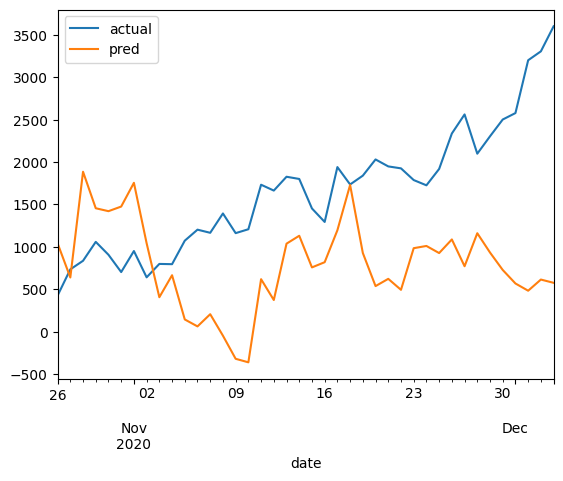

In [ ]:
# baseline model
model = Prophet()
for i in non_static_feature:
  model.add_regressor(i, standardize=False)
model.fit(train)
pred = model.predict(test.drop(columns = 'y'))
mape = mean_absolute_percentage_error(test.y, pred.yhat)
print(mape)

prediction = pd.DataFrame({'actual':test.y.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [ ]:
train = train.reset_index().drop(columns = 'index')

param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 0.5, 1.0, 10],
    'holidays_prior_scale':[0.01, 0.1, 0.5, 1.0, 10],
    'seasonality_mode': ['additive', 'multiplicative']
}

best_score, best_param = float("inf"), None

for param in ParameterGrid(param_grid):
    all_mse = 0
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      model = Prophet(**param, holidays = events, yearly_seasonality = False,
                      weekly_seasonality = False, daily_seasonality = False).add_country_holidays(
                          country_name='US').add_seasonality(
                              name='monthly', period=30.5, fourier_order=5)
      for i in non_static_feature:
        model.add_regressor(i, standardize=False)

      pred = model.fit(train_data).predict(val_data)
      mse = mean_squared_error(val_data.y, pred.yhat)
      all_mse = all_mse + mse
    print(f'params: {param} with mean MSE: {all_mse / 3}')
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best Prophet parameters: {best_param} with mean MSE: {best_score}')

params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 2237894.336533965
params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 2237894.3365340494
params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 2237894.3365340494
params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 2237894.3365340494
params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10} with mean MSE: 2237894.3365340494
params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} wi

<Axes: title={'center': 'Prediction versus Actual on Train Data'}, xlabel='Date', ylabel='Incremental Cases'>

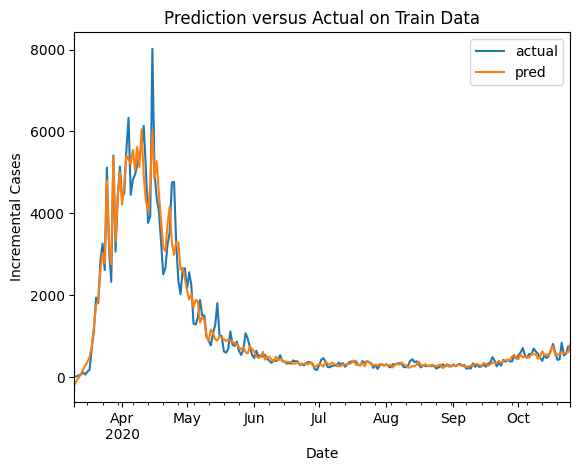

In [ ]:
model = Prophet(**best_param, holidays = events, yearly_seasonality = False,
                      weekly_seasonality = False, daily_seasonality = False).add_country_holidays(
                          country_name='US').add_seasonality(
                              name='monthly', period=30.5, fourier_order=5)
for i in non_static_feature:
  model.add_regressor(i, standardize=False)

model.fit(train)
pred = model.predict(train.drop(columns = 'y'))

prediction = pd.DataFrame({'actual':train.y.reset_index(drop = True),
              'pred':pred.yhat.reset_index(drop = True)})
prediction['date'] = train['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Train Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

0.42232411403221626


<Axes: title={'center': 'Prediction versus Actual on Test Data'}, xlabel='Date', ylabel='Incremental Cases'>

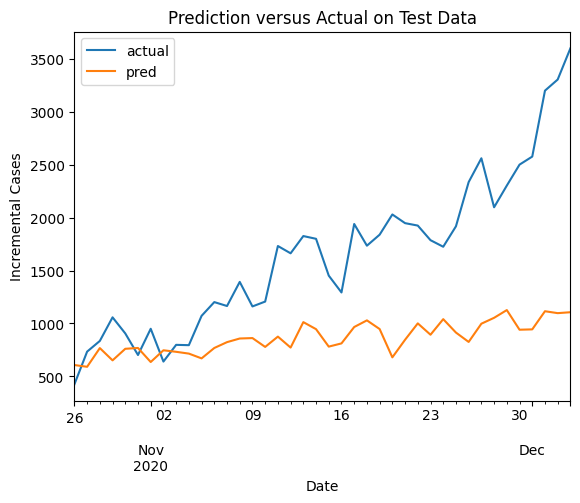

In [ ]:
pred = model.predict(test.drop(columns = 'y'))
mape = mean_absolute_percentage_error(test.y, pred.yhat)
print(mape)

prediction = pd.DataFrame({'actual':test.y.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Test Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

In [ ]:
train = train.reset_index().drop(columns = 'index')

param_grid = {
    'changepoint_prior_scale': [0.1, 0.5, 1, 3, 5],
    'seasonality_prior_scale': [0.001, 0.005, 0.01, 0.1],
    'holidays_prior_scale':[0.5, 1.0, 3, 5],
    'seasonality_mode': ['additive', 'multiplicative']
}

best_score, best_param = float("inf"), None

for param in ParameterGrid(param_grid):
    all_mse = 0
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      model = Prophet(**param, holidays = events, yearly_seasonality = False,
                      weekly_seasonality = False, daily_seasonality = False).add_country_holidays(
                          country_name='US').add_seasonality(
                              name='monthly', period=30.5, fourier_order=5)
      for i in non_static_feature:
        model.add_regressor(i, standardize=False)

      pred = model.fit(train_data).predict(val_data)
      mse = mean_squared_error(val_data.y, pred.yhat)
      all_mse = all_mse + mse
    print(f'params: {param} with mean MSE: {all_mse / 3}')
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best Prophet parameters: {best_param} with mean MSE: {best_score}')

params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001} with mean MSE: 264588.91489256814
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005} with mean MSE: 458346.3879367066
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 475360.87983516743
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 605589.1861740634
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001} with mean MSE: 387297.57897591026
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005} with me

<Axes: title={'center': 'Prediction versus Actual on Train Data'}, xlabel='Date', ylabel='Incremental Cases'>

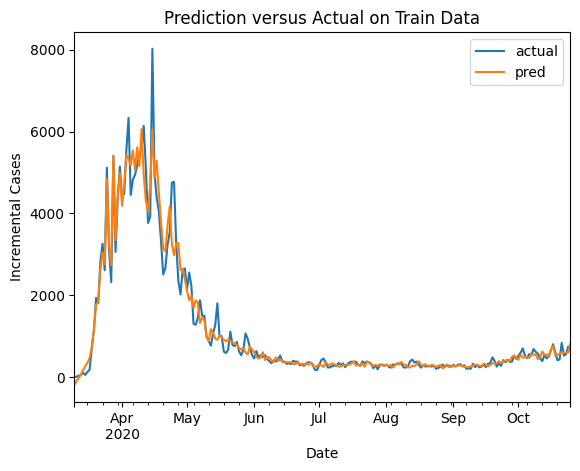

In [ ]:
model = Prophet(**best_param, holidays = events, yearly_seasonality = False,
                      weekly_seasonality = False, daily_seasonality = False).add_country_holidays(
                          country_name='US').add_seasonality(
                              name='monthly', period=30.5, fourier_order=5)
for i in non_static_feature:
  model.add_regressor(i, standardize=False)

model.fit(train)
pred = model.predict(train.drop(columns = 'y'))

prediction = pd.DataFrame({'actual':train.y.reset_index(drop = True),
              'pred':pred.yhat.reset_index(drop = True)})
prediction['date'] = train['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Train Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

0.41357409415978647


<Axes: title={'center': 'Prediction versus Actual on Test Data'}, xlabel='Date', ylabel='Incremental Cases'>

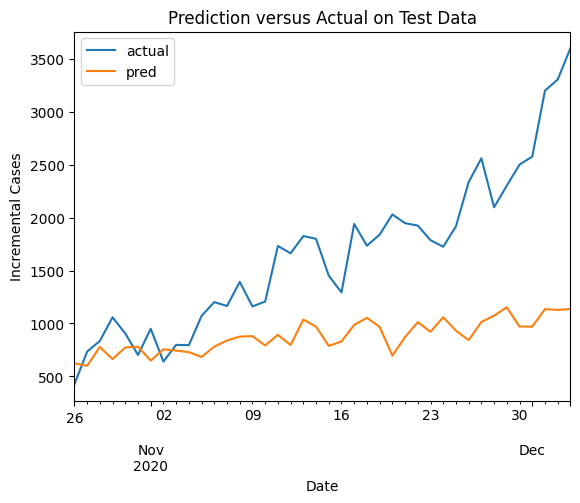

In [ ]:
pred = model.predict(test.drop(columns = 'y'))
mape = mean_absolute_percentage_error(test.y, pred.yhat)
print(mape)

prediction = pd.DataFrame({'actual':test.y.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Test Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

In [ ]:
param_grid = {
    'changepoint_prior_scale': [0.1, 0.5, 1, 2, 3],
    'seasonality_prior_scale': [0.001, 0.005, 0.01, 0.05, 0.1],
    'holidays_prior_scale':[0.1, 0.5, 1, 2, 3],
    'seasonality_mode': ['additive', 'multiplicative'],
    'weekly_seasonality': [True, False]
}

best_score, best_param = float("inf"), None

for param in ParameterGrid(param_grid):
    all_mse = 0
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      model = Prophet(**param, holidays = events, yearly_seasonality = False,
                      daily_seasonality = False).add_country_holidays(
                          country_name='US').add_seasonality(
                              name='monthly', period=30.5, fourier_order=5)
      for i in non_static_feature:
        model.add_regressor(i, standardize=False)

      pred = model.fit(train_data).predict(val_data)
      mse = mean_squared_error(val_data.y, pred.yhat)
      all_mse = all_mse + mse
    print(f'params: {param} with mean MSE: {all_mse / 3}')
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best Prophet parameters: {best_param} with mean MSE: {best_score}')

params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': True} with mean MSE: 668201.1154207216
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': False} with mean MSE: 972762.6633571306
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': True} with mean MSE: 699067.3365957326
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': False} with mean MSE: 789936.6744071301
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True} with mean MSE: 802743.3384829169
params: {'chan

<Axes: title={'center': 'Prediction versus Actual on Train Data'}, xlabel='Date', ylabel='Incremental Cases'>

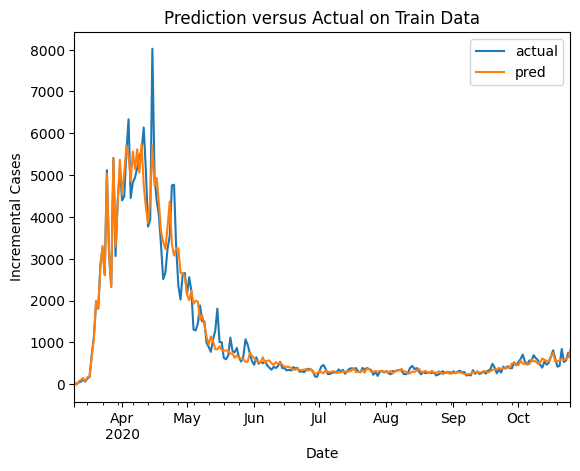

In [ ]:
model = Prophet(**best_param, holidays = events, yearly_seasonality = False,
                      daily_seasonality = False).add_country_holidays(
                          country_name='US').add_seasonality(
                              name='monthly', period=30.5, fourier_order=5)
for i in non_static_feature:
  model.add_regressor(i, standardize=False)

model.fit(train)
pred = model.predict(train.drop(columns = 'y'))

prediction = pd.DataFrame({'actual':train.y.reset_index(drop = True),
              'pred':pred.yhat.reset_index(drop = True)})
prediction['date'] = train['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Train Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

0.4088187342004722


<Axes: title={'center': 'Prediction versus Actual on Test Data'}, xlabel='Date', ylabel='Incremental Cases'>

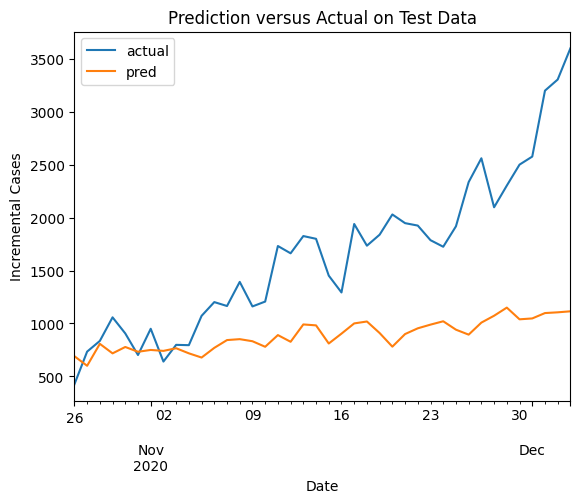

In [ ]:
pred = model.predict(test.drop(columns = 'y'))
mape = mean_absolute_percentage_error(test.y, pred.yhat)
print(mape)

prediction = pd.DataFrame({'actual':test.y.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Test Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

In [ ]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 0.5, 1.0, 10],
    'holidays_prior_scale':[0.01, 0.1, 0.5, 1.0, 10],
    'seasonality_mode': ['additive', 'multiplicative'],
    'weekly_seasonality':[True, False]
}

best_score, best_param = float("inf"), None

for param in ParameterGrid(param_grid):
    all_mse = 0
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      model = Prophet(**param, holidays = events, yearly_seasonality = False,
                      daily_seasonality = False).add_country_holidays(
                          country_name='US').add_seasonality(
                              name='monthly', period=30.5, fourier_order=5)
      for i in non_static_feature:
        model.add_regressor(i, standardize=False)

      pred = model.fit(train_data).predict(val_data)
      mse = mean_squared_error(val_data.y, pred.yhat)
      all_mse = all_mse + mse
    print(f'params: {param} with mean MSE: {all_mse / 3}')
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best Prophet parameters: {best_param} with mean MSE: {best_score}')

params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True} with mean MSE: 2237894.3236200116
params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False} with mean MSE: 2237894.336533965
params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': True} with mean MSE: 2237894.323620209
params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': False} with mean MSE: 2237894.3365340494
params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5, 'weekly_seasonality': True} with mean MSE: 2237894.323620209
para

<Axes: title={'center': 'Prediction versus Actual on Train Data'}, xlabel='Date', ylabel='Incremental Cases'>

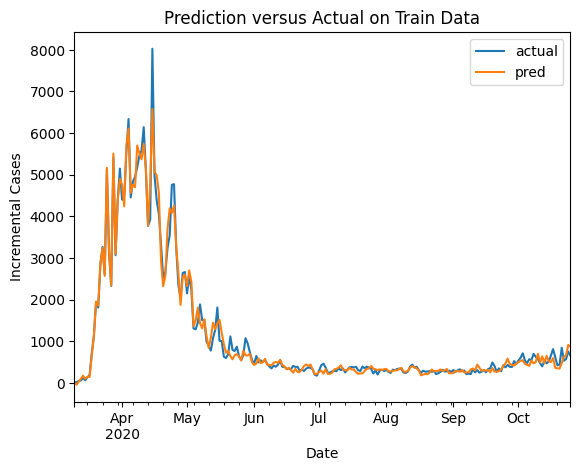

In [ ]:
model = Prophet(**best_param, holidays = events, yearly_seasonality = False,
                      daily_seasonality = False).add_country_holidays(
                          country_name='US').add_seasonality(
                              name='monthly', period=30.5, fourier_order=5)
for i in non_static_feature:
  model.add_regressor(i, standardize=False)

model.fit(train)
pred = model.predict(train.drop(columns = 'y'))

prediction = pd.DataFrame({'actual':train.y.reset_index(drop = True),
              'pred':pred.yhat.reset_index(drop = True)})
prediction['date'] = train['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Train Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

0.5536760836142868


<Axes: title={'center': 'Prediction versus Actual on Test Data'}, xlabel='Date', ylabel='Incremental Cases'>

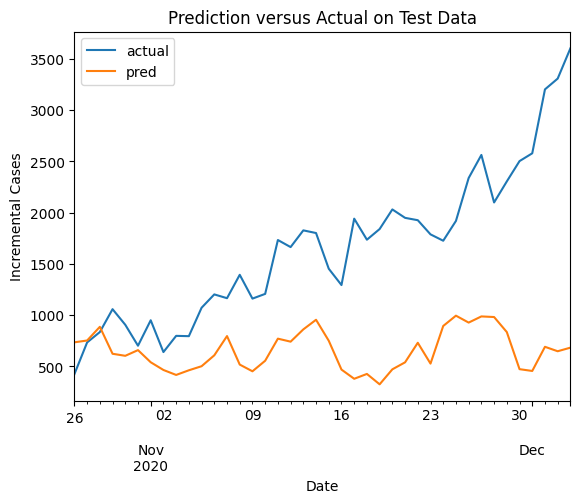

In [ ]:
pred = model.predict(test.drop(columns = 'y'))
mape = mean_absolute_percentage_error(test.y, pred.yhat)
print(mape)

prediction = pd.DataFrame({'actual':test.y.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Test Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

In [ ]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 0.5, 1.0, 10],
    'holidays_prior_scale':[0.01, 0.1, 0.5, 1.0, 10],
    'seasonality_mode': ['additive', 'multiplicative'],
    'weekly_seasonality':[True, False]
}

best_score, best_param = float("inf"), None

for param in ParameterGrid(param_grid):
    all_mse = 0
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      model = Prophet(**param, holidays = events, yearly_seasonality = False,
                      daily_seasonality = False).add_country_holidays(
                          country_name='US')
      for i in non_static_feature:
        model.add_regressor(i, standardize=False)

      pred = model.fit(train_data).predict(val_data)
      mse = mean_squared_error(val_data.y, pred.yhat)
      all_mse = all_mse + mse
    print(f'params: {param} with mean MSE: {all_mse / 3}')
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best Prophet parameters: {best_param} with mean MSE: {best_score}')

params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True} with mean MSE: 2237894.324124484
params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False} with mean MSE: 2237894.3370385445
params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': True} with mean MSE: 2237894.324124481
params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': False} with mean MSE: 2237894.3370385445
params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5, 'weekly_seasonality': True} with mean MSE: 2237894.324124481
para

<Axes: title={'center': 'Prediction versus Actual on Train Data'}, xlabel='Date', ylabel='Incremental Cases'>

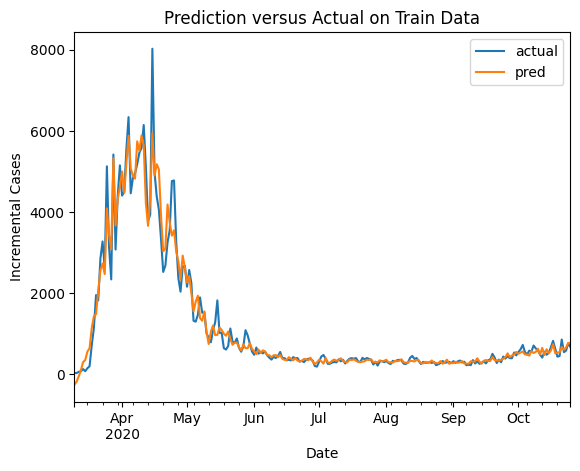

In [ ]:
model = Prophet(**best_param, holidays = events, yearly_seasonality = False,
                      daily_seasonality = False).add_country_holidays(
                          country_name='US')
for i in non_static_feature:
  model.add_regressor(i, standardize=False)

model.fit(train)
pred = model.predict(train.drop(columns = 'y'))

prediction = pd.DataFrame({'actual':train.y.reset_index(drop = True),
              'pred':pred.yhat.reset_index(drop = True)})
prediction['date'] = train['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Train Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

0.45851560409725123


<Axes: title={'center': 'Prediction versus Actual on Test Data'}, xlabel='Date', ylabel='Incremental Cases'>

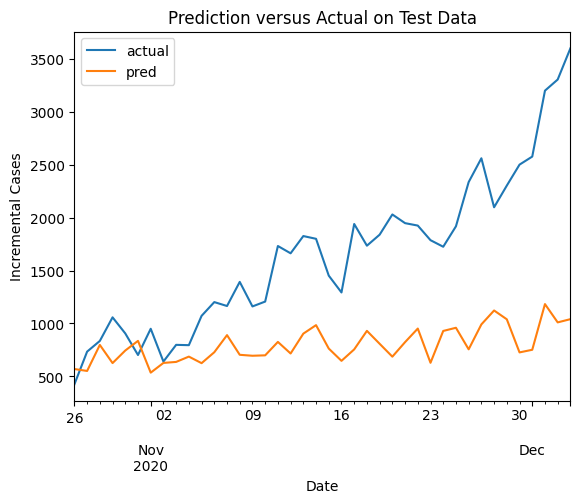

In [ ]:
pred = model.predict(test.drop(columns = 'y'))
mape = mean_absolute_percentage_error(test.y, pred.yhat)
print(mape)

prediction = pd.DataFrame({'actual':test.y.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Test Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

# Clark

In [ ]:
clark = data[data['entity'] == 'Nevada-Clark'].loc[:, col]
clark = clark.fillna(method='ffill')
clark['incremental_cases'] = clark['incremental_cases'].astype('int')
clark['date'] = pd.to_datetime(clark['date'], format="%Y-%m-%d")
clark = clark.rename(columns = {'date':'ds', 'incremental_cases':'y'})
clark['stay_at_home_announced'] = clark['stay_at_home_announced'].map({'yes':1, 'no':0})
clark['stay_at_home_effective'] = clark['stay_at_home_effective'].map({'yes':1, 'no':0})

# use 85%-15% for train-test split
train = clark.iloc[:230, :]
test = clark.iloc[230:, :]

0.6225701355798055


<Axes: xlabel='date'>

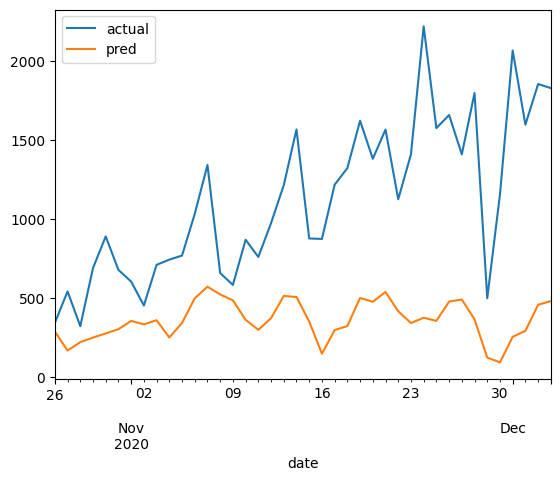

In [ ]:
model = Prophet()
for i in non_static_feature:
  model.add_regressor(i, standardize=False)
model.fit(train)
pred = model.predict(test.drop(columns = 'y'))
mape = mean_absolute_percentage_error(test.y, pred.yhat)
print(mape)

prediction = pd.DataFrame({'actual':test.y.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [ ]:
train = train.reset_index().drop(columns = 'index')

param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 0.5, 1.0, 10],
    'holidays_prior_scale':[0.01, 0.1, 0.5, 1.0, 10],
    'seasonality_mode': ['additive', 'multiplicative']
}

best_score, best_param = float("inf"), None

for param in ParameterGrid(param_grid):
    all_mse = 0
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      model = Prophet(**param, holidays = events, yearly_seasonality = False,
                      weekly_seasonality = False, daily_seasonality = False).add_country_holidays(
                          country_name='US').add_seasonality(
                              name='monthly', period=30.5, fourier_order=5)
      for i in non_static_feature:
        model.add_regressor(i, standardize=False)

      pred = model.fit(train_data).predict(val_data)
      mse = mean_squared_error(val_data.y, pred.yhat)
      all_mse = all_mse + mse
    print(f'params: {param} with mean MSE: {all_mse / 3}')
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best Prophet parameters: {best_param} with mean MSE: {best_score}')

params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 70341.39015912863
params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 70341.39015913471
params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 70341.39015913491
params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 70341.39015913491
params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10} with mean MSE: 70341.39015913491
params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with m

<Axes: title={'center': 'Prediction versus Actual on Train Data'}, xlabel='Date', ylabel='Incremental Cases'>

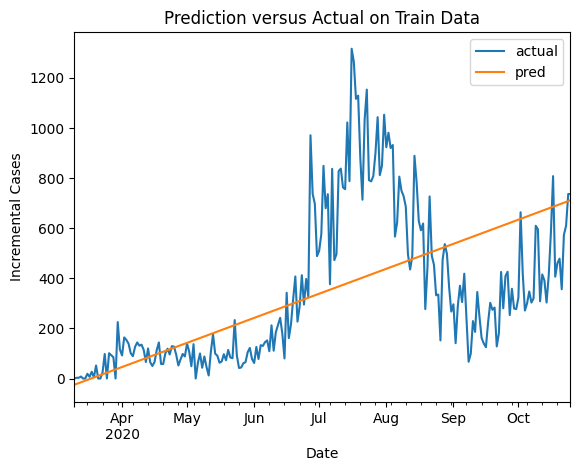

In [ ]:
model = Prophet(**best_param, holidays = events, yearly_seasonality = False,
                      weekly_seasonality = False, daily_seasonality = False).add_country_holidays(
                          country_name='US')
for i in non_static_feature:
  model.add_regressor(i, standardize=False)

model.fit(train)
pred = model.predict(train.drop(columns = 'y'))

prediction = pd.DataFrame({'actual':train.y.reset_index(drop = True),
              'pred':pred.yhat.reset_index(drop = True)})
prediction['date'] = train['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Train Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

0.3764384534466896


<Axes: title={'center': 'Prediction versus Actual on Test Data'}, xlabel='Date', ylabel='Incremental Cases'>

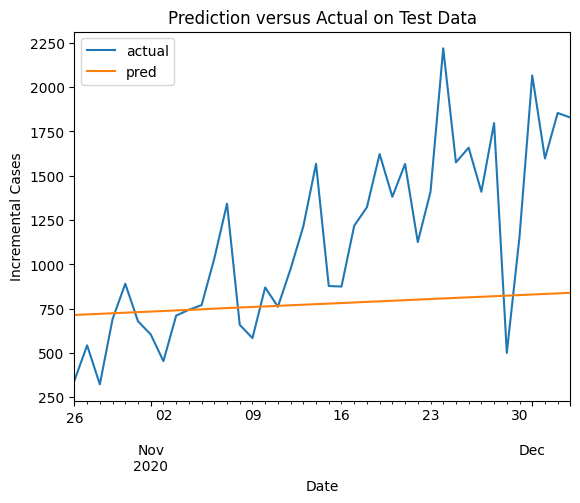

In [ ]:
pred = model.predict(test.drop(columns = 'y'))
mape = mean_absolute_percentage_error(test.y, pred.yhat)
print(mape)

prediction = pd.DataFrame({'actual':test.y.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Test Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

In [ ]:
train = train.reset_index().drop(columns = 'index')

param_grid = {
    'changepoint_prior_scale': [0.0001, 0.0005, 0.001, 0.01],
    'seasonality_prior_scale': [0.001, 0.005, 0.01, 0.1, 0.5],
    'holidays_prior_scale':[0.001, 0.005, 0.01, 0.1, 0.5],
    'seasonality_mode': ['additive', 'multiplicative']
}

best_score, best_param = float("inf"), None

for param in ParameterGrid(param_grid):
    all_mse = 0
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      model = Prophet(**param, holidays = events, yearly_seasonality = False,
                      weekly_seasonality = False, daily_seasonality = False).add_country_holidays(
                          country_name='US').add_seasonality(
                              name='monthly', period=30.5, fourier_order=5)
      for i in non_static_feature:
        model.add_regressor(i, standardize=False)

      pred = model.fit(train_data).predict(val_data)
      mse = mean_squared_error(val_data.y, pred.yhat)
      all_mse = all_mse + mse
    print(f'params: {param} with mean MSE: {all_mse / 3}')
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best Prophet parameters: {best_param} with mean MSE: {best_score}')

params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001} with mean MSE: 135194.83042451498


params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005} with mean MSE: 134436.020661018


params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 144261.54577550385


params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 160960.59699084947


params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 199828.05249611926
params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001} with mean MSE: 182078.5229375443
params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005} with mean MSE: 182078.52293779075
params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 182078.52293779596
params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 182078.52293780167
params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.001, 'seasonality_mode': 'multiplicat

params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001} with mean MSE: 245633.96930912303


params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005} with mean MSE: 246989.13266246952


params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 250170.1846854426


params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 278551.69137299445


params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 283469.63800457335
params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001} with mean MSE: 221676.72929091973
params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005} with mean MSE: 221676.72917476925
params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 221676.7291708726
params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 221676.72916958528
params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'multiplicat

params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001} with mean MSE: 255110.22687419446


params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005} with mean MSE: 255676.73233331216


params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 257069.22401990768


params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 260344.90907346967


params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 297730.7541887323
params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001} with mean MSE: 227839.76549596852
params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005} with mean MSE: 227839.7668528362
params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 227839.76685281793
params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 227839.76685281112
params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', '

params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001} with mean MSE: 241616.5094822098


params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005} with mean MSE: 242197.11973535657


params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 243545.89510589305


params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 233121.6788229933


params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 219860.1314465145
params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001} with mean MSE: 232486.39201863916
params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005} with mean MSE: 232486.39190506292
params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 232486.39190259363
params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 232486.39190143067
params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seaso

params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001} with mean MSE: 181247.743144666


params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005} with mean MSE: 215566.28815901434


params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 242789.02983423634


params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 217521.65845030188


params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 247758.81432840088
params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001} with mean MSE: 232487.23272511052
params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005} with mean MSE: 232487.23272334217
params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 232487.23272340724
params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 232487.23272344528
params: {'changepoint_prior_scale': 0.0001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seas

In [ ]:
param_grid = {
    'changepoint_prior_scale': [0.0003, 0.0005, 0.0007, 0.0009],
    'seasonality_prior_scale': [0.0001, 0.0005, 0.001, 0.005, 0.01],
    'holidays_prior_scale':[0.0001, 0.0005, 0.001, 0.005, 0.01],
    'seasonality_mode': ['additive', 'multiplicative']
}

best_score, best_param = float("inf"), None

for param in ParameterGrid(param_grid):
    all_mse = 0
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      model = Prophet(**param, holidays = events, yearly_seasonality = False,
                      weekly_seasonality = False, daily_seasonality = False).add_country_holidays(
                          country_name='US').add_seasonality(
                              name='monthly', period=30.5, fourier_order=5)
      for i in non_static_feature:
        model.add_regressor(i, standardize=False)

      pred = model.fit(train_data).predict(val_data)
      mse = mean_squared_error(val_data.y, pred.yhat)
      all_mse = all_mse + mse
    print(f'params: {param} with mean MSE: {all_mse / 3}')
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best Prophet parameters: {best_param} with mean MSE: {best_score}')

params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.0001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0001} with mean MSE: 149166.00091488994


params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.0001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0005} with mean MSE: 149149.93943253288


params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.0001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001} with mean MSE: 149100.30447464998


params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.0001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005} with mean MSE: 147516.3690446122


params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.0001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 142865.82370446544
params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.0001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0001} with mean MSE: 93842.71146766613
params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.0001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0005} with mean MSE: 93842.7114765738
params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.0001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001} with mean MSE: 93842.71147686314
params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.0001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005} with mean MSE: 93842.71147695946
params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.0001, 'seasonality_mode': 'mul

params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.0005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0001} with mean MSE: 124272.54374232494


params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.0005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0005} with mean MSE: 124251.32017312455


params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.0005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001} with mean MSE: 124171.00864147388


params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.0005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005} with mean MSE: 121914.51816977894


params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.0005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 126571.14883693778
params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.0005, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0001} with mean MSE: 166742.66312495337
params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.0005, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0005} with mean MSE: 166742.6661666253
params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.0005, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001} with mean MSE: 166742.6842052565
params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.0005, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005} with mean MSE: 166742.68420506854
params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.0005, 'seasonality_mode': '

params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0001} with mean MSE: 146633.2421449043


params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0005} with mean MSE: 146590.5629033321


params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001} with mean MSE: 146449.12593824227


params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005} with mean MSE: 148885.75001465928


params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 161760.6409556239
params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0001} with mean MSE: 182370.48653196846
params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0005} with mean MSE: 182370.902510862
params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001} with mean MSE: 182370.9054988519
params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005} with mean MSE: 182370.903974637
params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.001, 'seasonality_mode': 'multiplica

params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0001} with mean MSE: 243869.05803585914


params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0005} with mean MSE: 243885.77824992963


params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001} with mean MSE: 243922.84242840318


params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005} with mean MSE: 245920.21143393044


params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 248616.08063748103
params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0001} with mean MSE: 221799.14707595608
params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0005} with mean MSE: 221798.15636094028
params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001} with mean MSE: 221798.15636534206
params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005} with mean MSE: 221798.1577260569
params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'multi

params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0001} with mean MSE: 254392.71978064068


params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0005} with mean MSE: 254397.34247395667


params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001} with mean MSE: 254408.3347726214


params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005} with mean MSE: 255005.413944168


params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 256429.625231411
params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0001} with mean MSE: 226465.86810428544
params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0005} with mean MSE: 226466.48760459622
params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001} with mean MSE: 226466.48760606386
params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005} with mean MSE: 226466.48761030321
params: {'changepoint_prior_scale': 0.0003, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicati

<Axes: title={'center': 'Prediction versus Actual on Train Data'}, xlabel='Date', ylabel='Incremental Cases'>

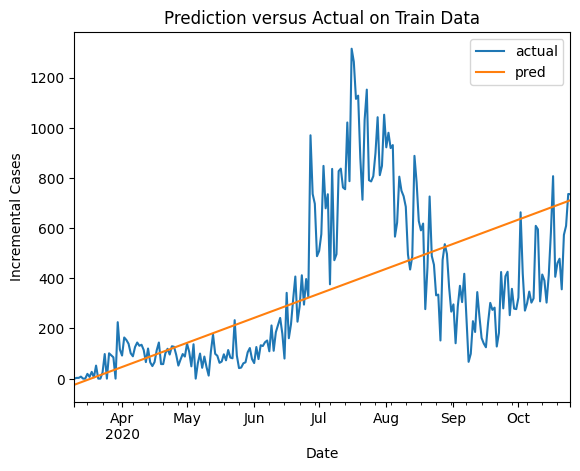

In [ ]:
model = Prophet(**best_param, holidays = events, yearly_seasonality = False,
                      weekly_seasonality = False, daily_seasonality = False).add_country_holidays(
                          country_name='US')
for i in non_static_feature:
  model.add_regressor(i, standardize=False)

model.fit(train)
pred = model.predict(train.drop(columns = 'y'))

prediction = pd.DataFrame({'actual':train.y.reset_index(drop = True),
              'pred':pred.yhat.reset_index(drop = True)})
prediction['date'] = train['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Train Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

0.3764387589142669


<Axes: title={'center': 'Prediction versus Actual on Test Data'}, xlabel='Date', ylabel='Incremental Cases'>

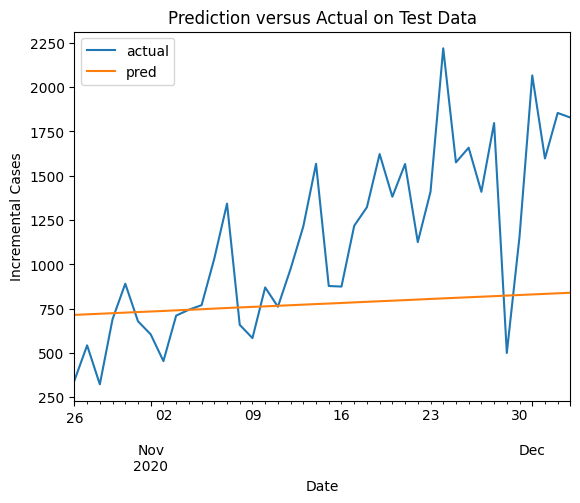

In [ ]:
pred = model.predict(test.drop(columns = 'y'))
mape = mean_absolute_percentage_error(test.y, pred.yhat)
print(mape)

prediction = pd.DataFrame({'actual':test.y.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Test Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

<Axes: title={'center': 'Prediction versus Actual on Train Data'}, xlabel='Date', ylabel='Incremental Cases'>

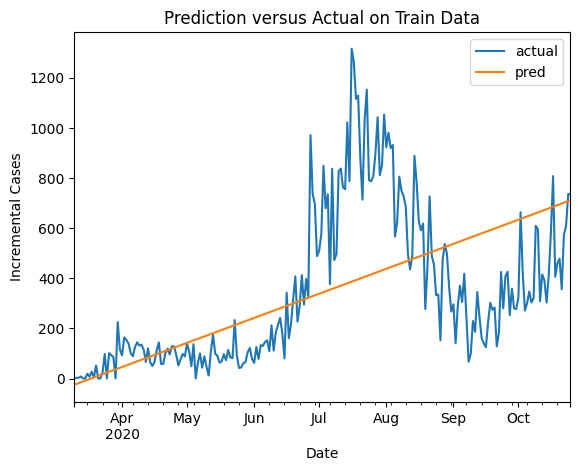

In [ ]:
model = Prophet(**best_param, holidays = events, yearly_seasonality = False,
                      weekly_seasonality = False, daily_seasonality = False).add_country_holidays(
                          country_name='US')
for i in non_static_feature:
  model.add_regressor(i, standardize=False)

model.fit(train)
pred = model.predict(train.drop(columns = 'y'))

prediction = pd.DataFrame({'actual':train.y.reset_index(drop = True),
              'pred':pred.yhat.reset_index(drop = True)})
prediction['date'] = train['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Train Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

0.3764383272763769


<Axes: title={'center': 'Prediction versus Actual on Test Data'}, xlabel='Date', ylabel='Incremental Cases'>

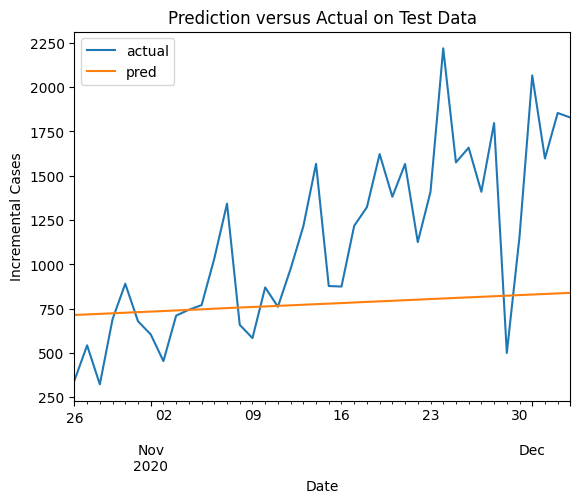

In [ ]:
pred = model.predict(test.drop(columns = 'y'))
mape = mean_absolute_percentage_error(test.y, pred.yhat)
print(mape)

prediction = pd.DataFrame({'actual':test.y.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Test Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

# Suffolk

In [ ]:
suffolk = data[data['entity'] == 'New York-Suffolk'].loc[:, col]
suffolk = suffolk.fillna(method='ffill')
suffolk['incremental_cases'] = suffolk['incremental_cases'].astype('int')
suffolk['date'] = pd.to_datetime(suffolk['date'], format="%Y-%m-%d")
suffolk = suffolk.rename(columns = {'date':'ds', 'incremental_cases':'y'})
suffolk['stay_at_home_announced'] = suffolk['stay_at_home_announced'].map({'yes':1, 'no':0})
suffolk['stay_at_home_effective'] = suffolk['stay_at_home_effective'].map({'yes':1, 'no':0})

# use 85%-15% for train-test split
train = suffolk.iloc[:230, :]
test = suffolk.iloc[230:, :]

0.9493987624562441


<Axes: xlabel='date'>

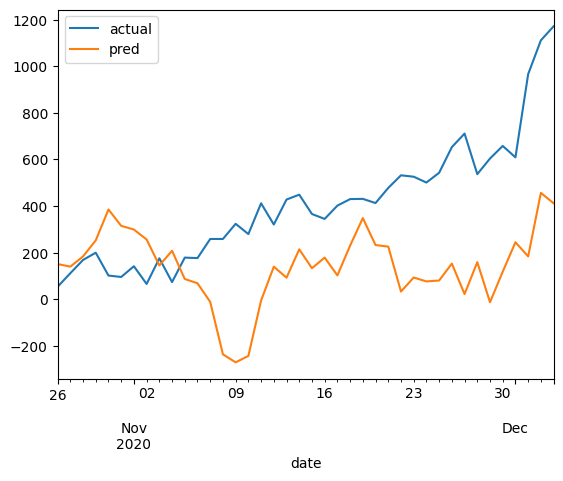

In [ ]:
model = Prophet()
for i in non_static_feature:
  model.add_regressor(i, standardize=False)
model.fit(train)
pred = model.predict(test.drop(columns = 'y'))
mape = mean_absolute_percentage_error(test.y, pred.yhat)
print(mape)

prediction = pd.DataFrame({'actual':test.y.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [ ]:
train = train.reset_index().drop(columns = 'index')

param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 0.5, 1.0, 10],
    'holidays_prior_scale':[0.01, 0.1, 0.5, 1.0, 10],
    'seasonality_mode': ['additive', 'multiplicative']
}

best_score, best_param = float("inf"), None

for param in ParameterGrid(param_grid):
    all_mse = 0
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      model = Prophet(**param, holidays = events, yearly_seasonality = False,
                      weekly_seasonality = False, daily_seasonality = False).add_country_holidays(
                          country_name='US').add_seasonality(
                              name='monthly', period=30.5, fourier_order=5)
      for i in non_static_feature:
        model.add_regressor(i, standardize=False)

      pred = model.fit(train_data).predict(val_data)
      mse = mean_squared_error(val_data.y, pred.yhat)
      all_mse = all_mse + mse
    print(f'params: {param} with mean MSE: {all_mse / 3}')
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best Prophet parameters: {best_param} with mean MSE: {best_score}')

params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 82404.58608646644
params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 82404.5860864768
params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 82404.5860864768
params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 82404.5860864768
params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10} with mean MSE: 82404.5860864768


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 174771.68948819418


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 180405.31794014457


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5} with mean MSE: 186587.24674708906


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 182064.812655155


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10} with mean MSE: 141721.50098457062
params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 82415.80998943538
params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 82415.80998943537
params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 82415.80998943537
params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 82415.80998943537
params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10} with mean MS

params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 162307.96465435636


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 166388.8906337748


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5} with mean MSE: 167319.21499456896


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 167912.1022090838


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10} with mean MSE: 166574.68345368406
params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 82415.81345674452
params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 82415.81345675485
params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 82415.81345675485
params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 82415.81345675485
params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10} with mean MSE

params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 177157.51644044137


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 161883.3177791118


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5} with mean MSE: 168825.92509058912


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 164587.25731083655


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10} with mean MSE: 163850.04695649294
params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 82415.81361428065
params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 82415.81361429098
params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 82415.81361429098
params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 82415.81361429098
params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10} with mean MSE

params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 165740.25271457632


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 173053.53717157047


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5} with mean MSE: 168048.10767426225


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 162488.82326221772


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10} with mean MSE: 161745.67650266786
params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 82415.81361428063
params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 82415.81361429098
params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 82415.81361429098
params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 82415.81361429098
params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10} with mean MSE: 824

params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 165289.77527597098


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 168647.43317786514


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5} with mean MSE: 163793.0730266126


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 168982.8846699261


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10} with mean MSE: 160065.59744677859
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 28677.068429309627
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 57078.7820857994
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 55049.2767290989
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 58633.07272218156
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10} with mean MSE: 

<Axes: title={'center': 'Prediction versus Actual on Train Data'}, xlabel='Date', ylabel='Incremental Cases'>

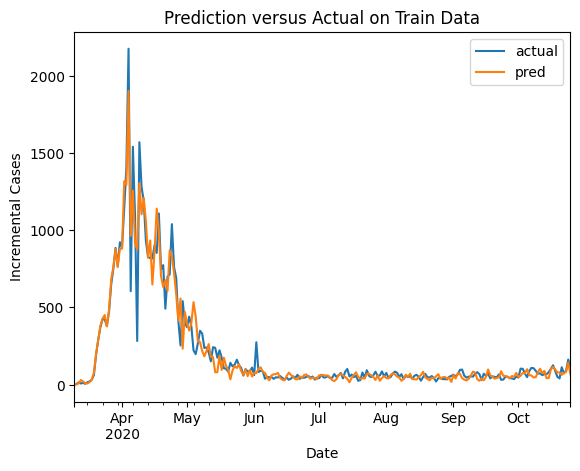

In [ ]:
model = Prophet(**best_param, holidays = events, yearly_seasonality = False,
                      weekly_seasonality = False, daily_seasonality = False).add_country_holidays(
                          country_name='US').add_seasonality(
                              name='monthly', period=30.5, fourier_order=5)
for i in non_static_feature:
  model.add_regressor(i, standardize=False)

model.fit(train)
pred = model.predict(train.drop(columns = 'y'))

prediction = pd.DataFrame({'actual':train.y.reset_index(drop = True),
              'pred':pred.yhat.reset_index(drop = True)})
prediction['date'] = train['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Train Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

0.6765267380051894


<Axes: title={'center': 'Prediction versus Actual on Test Data'}, xlabel='Date', ylabel='Incremental Cases'>

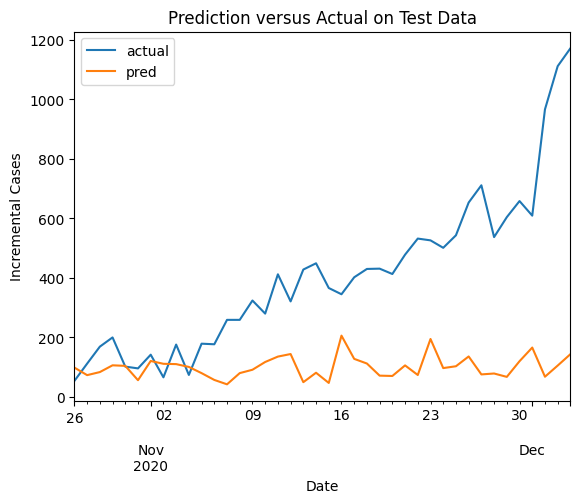

In [ ]:
pred = model.predict(test.drop(columns = 'y'))
mape = mean_absolute_percentage_error(test.y, pred.yhat)
print(mape)

prediction = pd.DataFrame({'actual':test.y.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Test Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

In [ ]:
param_grid = {
    'changepoint_prior_scale': [0.1, 0.5, 1, 2, 3],
    'seasonality_prior_scale': [0.1, 0.3, 0.5, 0.7, 1.0],
    'holidays_prior_scale':[0.1, 0.3, 0.5, 0.7, 1.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

best_score, best_param = float("inf"), None

for param in ParameterGrid(param_grid):
    all_mse = 0
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      model = Prophet(**param, holidays = events, yearly_seasonality = False,
                      weekly_seasonality = False, daily_seasonality = False).add_country_holidays(
                          country_name='US').add_seasonality(
                              name='monthly', period=30.5, fourier_order=5)
      for i in non_static_feature:
        model.add_regressor(i, standardize=False)

      pred = model.fit(train_data).predict(val_data)
      mse = mean_squared_error(val_data.y, pred.yhat)
      all_mse = all_mse + mse
    print(f'params: {param} with mean MSE: {all_mse / 3}')
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best Prophet parameters: {best_param} with mean MSE: {best_score}')

params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 37778.99597493845
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3} with mean MSE: 31173.633259026286
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 35439.28852697809
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7} with mean MSE: 34943.85210780204
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 39620.30101748264
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 22125.948

In [ ]:
model = Prophet(**best_param, holidays = events, yearly_seasonality = False,
                      weekly_seasonality = False, daily_seasonality = False).add_country_holidays(
                          country_name='US').add_seasonality(
                              name='monthly', period=30.5, fourier_order=5)
for i in non_static_feature:
  model.add_regressor(i, standardize=False)

model.fit(train)
pred = model.predict(train.drop(columns = 'y'))

prediction = pd.DataFrame({'actual':train.y.reset_index(drop = True),
              'pred':pred.yhat.reset_index(drop = True)})
prediction['date'] = train['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Train Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

In [ ]:
pred = model.predict(test.drop(columns = 'y'))
mape = mean_absolute_percentage_error(test.y, pred.yhat)
print(mape)

prediction = pd.DataFrame({'actual':test.y.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Test Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

In [ ]:
param_grid = {
    'changepoint_prior_scale': [1, 3, 5, 7],
    'seasonality_prior_scale': [0.05, 0.08, 0.1, 0.3],
    'holidays_prior_scale':[ 0.4, 0.5, 0.6],
    'seasonality_mode': ['additive', 'multiplicative']
}

best_score, best_param = float("inf"), None

for param in ParameterGrid(param_grid):
    all_mse = 0
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      model = Prophet(**param, holidays = events, yearly_seasonality = False,
                      weekly_seasonality = False, daily_seasonality = False).add_country_holidays(
                          country_name='US').add_seasonality(
                              name='monthly', period=30.5, fourier_order=5)
      for i in non_static_feature:
        model.add_regressor(i, standardize=False)

      pred = model.fit(train_data).predict(val_data)
      mse = mean_squared_error(val_data.y, pred.yhat)
      all_mse = all_mse + mse
    print(f'params: {param} with mean MSE: {all_mse / 3}')
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best Prophet parameters: {best_param} with mean MSE: {best_score}')

params: {'changepoint_prior_scale': 1, 'holidays_prior_scale': 0.4, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.05} with mean MSE: 12953.773656340476
params: {'changepoint_prior_scale': 1, 'holidays_prior_scale': 0.4, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.08} with mean MSE: 5673.257506023732
params: {'changepoint_prior_scale': 1, 'holidays_prior_scale': 0.4, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 8309.913351512052
params: {'changepoint_prior_scale': 1, 'holidays_prior_scale': 0.4, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3} with mean MSE: 12104.3894600037
params: {'changepoint_prior_scale': 1, 'holidays_prior_scale': 0.4, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.05} with mean MSE: 3071.6863843673946
params: {'changepoint_prior_scale': 1, 'holidays_prior_scale': 0.4, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.08} with mean MSE: 2027.198145

<Axes: title={'center': 'Prediction versus Actual on Train Data'}, xlabel='Date', ylabel='Incremental Cases'>

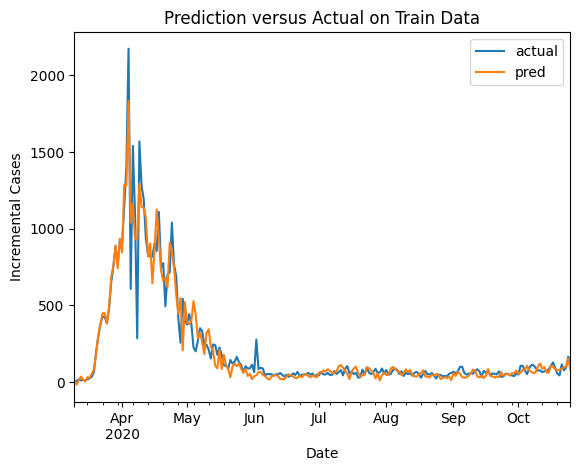

In [ ]:
model = Prophet(**best_param, holidays = events, yearly_seasonality = False,
                      weekly_seasonality = False, daily_seasonality = False).add_country_holidays(
                          country_name='US').add_seasonality(
                              name='monthly', period=30.5, fourier_order=5)
for i in non_static_feature:
  model.add_regressor(i, standardize=False)

model.fit(train)
pred = model.predict(train.drop(columns = 'y'))

prediction = pd.DataFrame({'actual':train.y.reset_index(drop = True),
              'pred':pred.yhat.reset_index(drop = True)})
prediction['date'] = train['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Train Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

0.6540355400320628


<Axes: title={'center': 'Prediction versus Actual on Test Data'}, xlabel='Date', ylabel='Incremental Cases'>

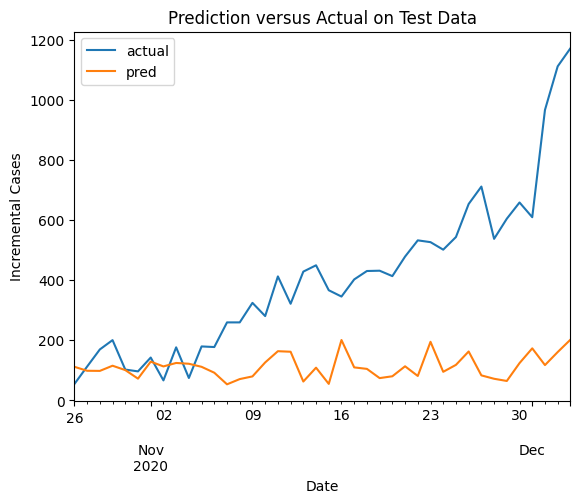

In [ ]:
pred = model.predict(test.drop(columns = 'y'))
mape = mean_absolute_percentage_error(test.y, pred.yhat)
print(mape)

prediction = pd.DataFrame({'actual':test.y.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Test Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

In [ ]:
from prophet.diagnostics import cross_validation, performance_metrics
df_cv = cross_validation(model, horizon = '40 days', parallel="processes")
performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,4 days,24590.072959,156.812222,135.250175,0.364741,0.226207,0.275910,1.0
1,5 days,17977.600000,134.080573,121.049357,0.277562,0.228468,0.243753,1.0
2,6 days,22094.348768,148.641679,131.676645,0.394009,0.264817,0.290222,1.0
3,7 days,31075.125878,176.281383,163.075930,0.585925,0.371312,0.388420,1.0
4,8 days,33683.831132,183.531554,170.459268,0.586408,0.371312,0.392892,1.0
5,9 days,32085.909542,179.125402,163.072866,0.555242,0.295914,0.370285,1.0
6,10 days,20845.141420,144.378466,121.835565,0.380571,0.169278,0.271272,1.0
7,11 days,11036.098350,105.052836,84.063059,0.164900,0.133098,0.150790,1.0
8,12 days,10508.241005,102.509712,85.323368,0.210124,0.133098,0.175650,1.0
9,13 days,26148.410249,161.704701,116.265499,0.593829,0.134089,0.284030,1.0


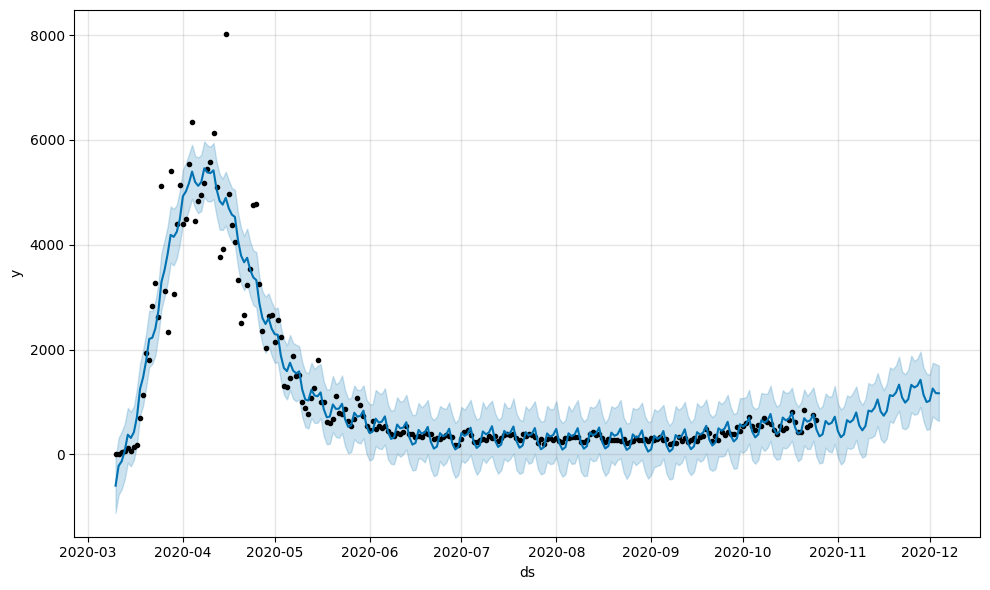

In [ ]:
model = Prophet(yearly_seasonality=True, weekly_seasonality=True).fit(train)
pred = model.predict(model.make_future_dataframe(periods=40))
model.plot(pred);

-0.607206395200864


<Axes: xlabel='date'>

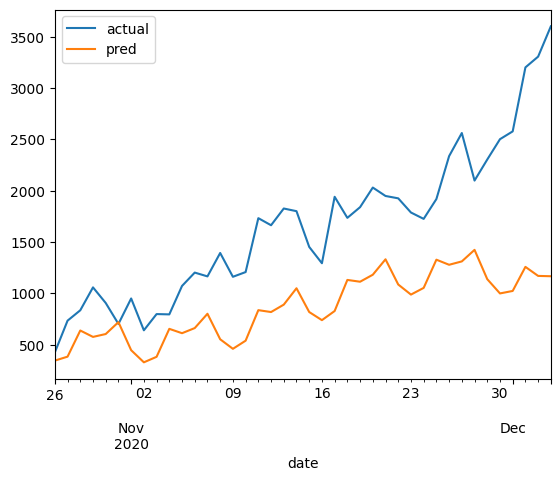

In [ ]:
r2 = r2_score(test.incremental_cases, pred.tail(40).yhat)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [ ]:
tscv = TimeSeriesSplit(n_splits = 5)

train = train.reset_index().drop(columns = 'index')

param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1],
    'seasonality_prior_scale': [0.01, 0.1, 1.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

best_score, best_param = float("inf"), None

for param in ParameterGrid(param_grid):
    all_mse = 0
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      model = Prophet(**param).fit(train_data)
      pred = model.predict(val_data)
      mse = mean_squared_error(val_data.y, pred.yhat)
      all_mse = all_mse + mse
    print(f'params: {param} with mean MSE: {all_mse / 3}')
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best Prophet parameters: {best_param} with mean MSE: {best_score}')


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 24022509.902335506


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 24045688.499234576


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 25447988.24518862


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 24119485.750381846


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 25905948.7448229


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 23652886.61148454


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 24022509.902335506


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 24045688.499234576


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 25447988.24518862


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 24119485.750381846


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 25905948.7448229


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 23652886.61148454


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 24022509.902335506


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 24045688.499234576


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 25447988.24518862


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 24119485.750381846


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 25905948.7448229


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 23652886.61148454
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 24121847.39662145
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 24044876.559156273
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 23800333.93202256
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 24330212.95235014
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1

-1.5587111668777816


<Axes: xlabel='date'>

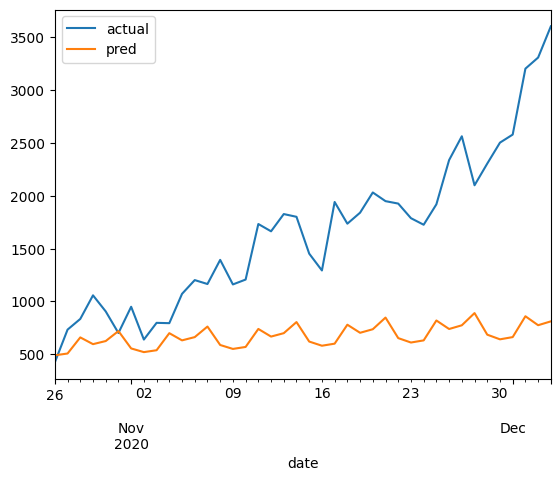

In [ ]:
model = Prophet(**best_param).fit(train)
pred = model.predict(model.make_future_dataframe(periods=40))
r2 = r2_score(test.incremental_cases, pred.tail(40).yhat)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [ ]:
param_grid = {
    'changepoint_prior_scale': [0.05, 0.075, 0.1, 0.125, 0.15],
    'seasonality_prior_scale': [0.05, 0.075, 0.1, 0.125, 0.15],
    'holidays_prior_scale': [0.005, 0.01, 0.015, 0.02],
    'seasonality_mode': ['additive', 'multiplicative']
}

best_score, best_param = float("inf"), None

for param in ParameterGrid(param_grid):
    all_mse = 0
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      model = Prophet(**param).fit(train_data)
      pred = model.predict(val_data)
      mse = mean_squared_error(val_data.y, pred.yhat)
      all_mse = all_mse + mse
    print(f'params: {param} with mean MSE: {all_mse / 3}')
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best Prophet parameters: {best_param} with mean MSE: {best_score}')

params: {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.05} with mean MSE: 25743432.701915894
params: {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.075} with mean MSE: 25790126.413834292
params: {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 25466119.417116057
params: {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.125} with mean MSE: 25676519.168601677
params: {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.15} with mean MSE: 25676579.355273675
params: {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0

-1.5052319063067783


<Axes: xlabel='date'>

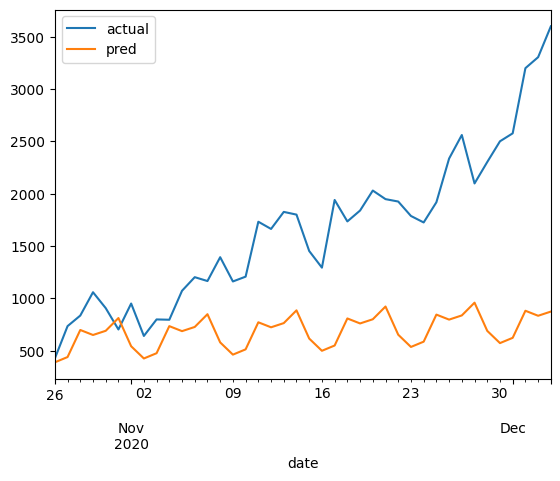

In [ ]:
model = Prophet(**best_param).fit(train)
pred = model.predict(model.make_future_dataframe(periods=40))
r2 = r2_score(test.incremental_cases, pred.tail(40).yhat)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

# Multivariate Prophet

In [ ]:
nyc = data[data['entity'] == 'New York-New York City'].drop(columns = 'cases')
nyc['incremental_cases'] = nyc['incremental_cases'].astype('int')
nyc['date'] = pd.to_datetime(nyc['date'], format="%Y-%m-%d")
nyc['stay_at_home_announced'] = nyc['stay_at_home_announced'].map({'yes':1, 'no':0})
nyc['stay_at_home_effective'] = nyc['stay_at_home_effective'].map({'yes':1, 'no':0})

non_static = []
def static_check(df):
  for i in df.columns:
    num_unique = len(df[i].unique())
    if num_unique != 1:
      non_static.append(i)
  return non_static

static_check(nyc)
nyc = nyc.loc[:, non_static].drop(columns = 'station_name').rename(columns = {'date':'ds', 'incremental_cases':'y'})

train = nyc.iloc[:230, :]
test = nyc.iloc[230:, :]

In [ ]:
nyc.columns

Index(['ds', 'stay_at_home_announced', 'stay_at_home_effective', 'mean_temp',
       'min_temp', 'max_temp', 'dewpoint', 'sea_level_pressure', 'visibility',
       'wind_speed', 'max_wind_speed', 'precipitation', 'precip_flag', 'fog',
       'rain', 'snow', 'hail', 'thunder', 'tornado', 'mean_temp_3d_avg',
       'max_temp_3d_avg', 'min_temp_3d_avg', 'dewpoint_3d_avg', 'y'],
      dtype='object')

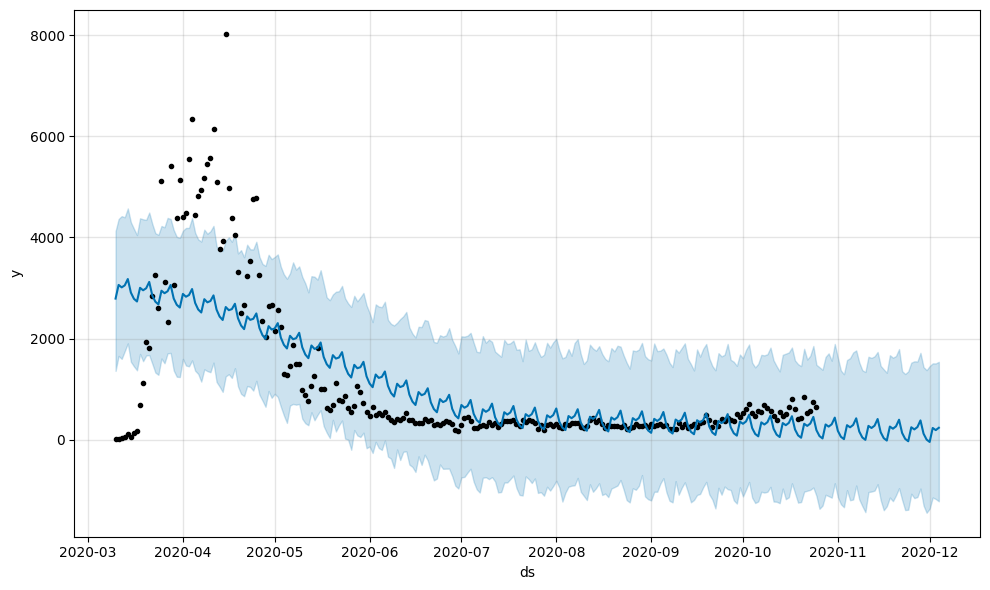

In [ ]:
# baseline model
model_baseline = Prophet()
model_baseline.fit(train)

future_baseline = model_baseline.make_future_dataframe(periods=40)
forecast_baseline = model_baseline.predict(future_baseline)
model_baseline.plot(forecast_baseline);

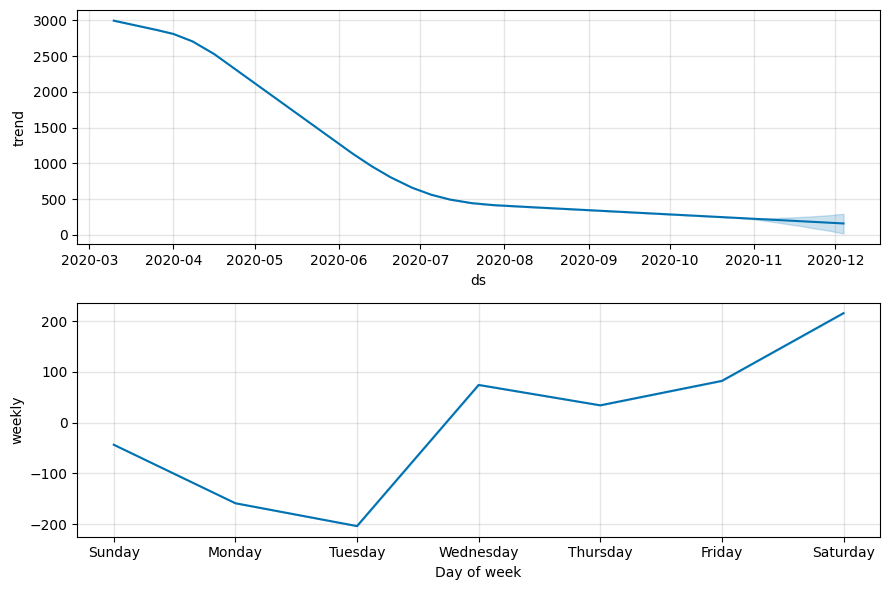

In [ ]:
model_baseline.plot_components(forecast_baseline);

In [ ]:
performance_baseline = pd.merge(test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-40:], on='ds')

performance_baseline_MAE = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAE for the baseline model is {performance_baseline_MAE}')

performance_baseline_MAPE = mean_absolute_percentage_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAPE for the baseline model is {performance_baseline_MAPE}')

The MAE for the baseline model is 1461.1566112952082
The MAPE for the baseline model is 0.8570759844057416


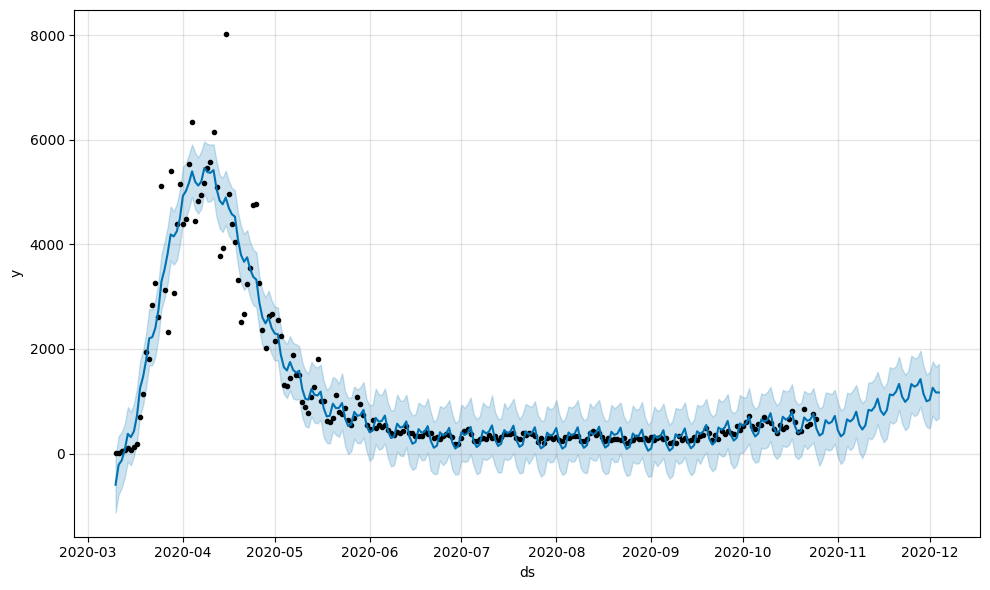

In [ ]:
# Add seasonality
model_season = Prophet(yearly_seasonality=True, weekly_seasonality=True)
model_season.fit(train)
future_season = model_season.make_future_dataframe(periods=40)
forecast_season = model_season.predict(future_season)
model_season.plot(forecast_season);

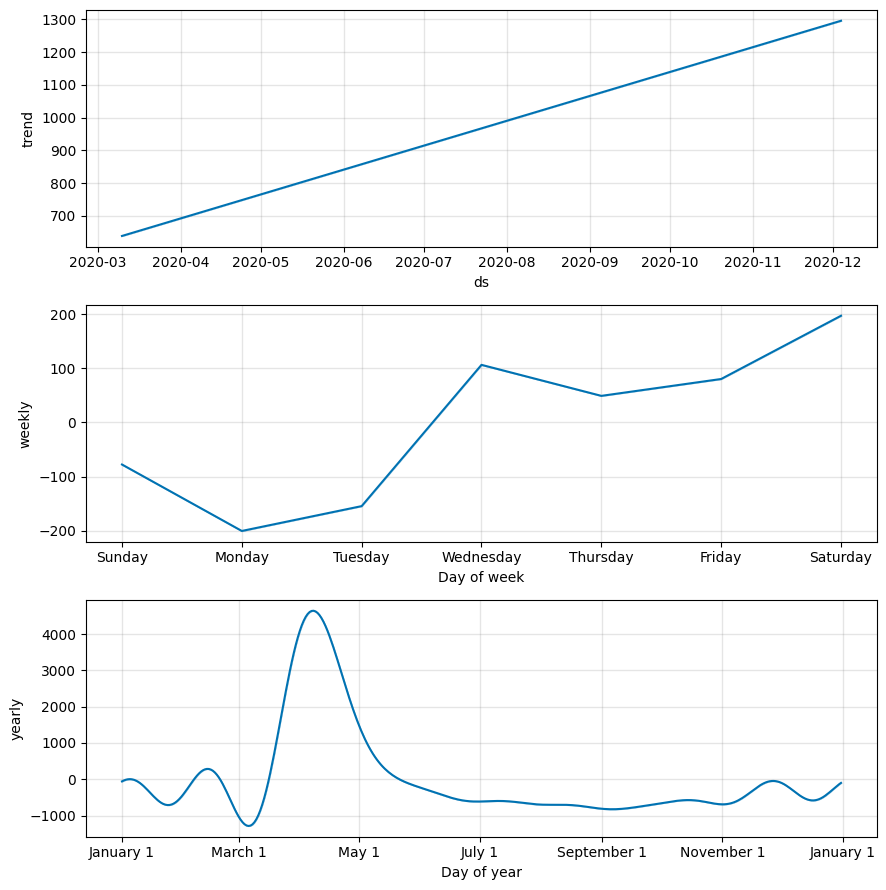

In [ ]:
model_season.plot_components(forecast_season);

In [ ]:
performance_season = pd.merge(test, forecast_season[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-40:], on='ds')

performance_season_MAE = mean_absolute_error(performance_season['y'], performance_season['yhat'])
print(f'The MAE for the seasonality model is {performance_season_MAE}')

performance_season_MAPE = mean_absolute_percentage_error(performance_season['y'], performance_season['yhat'])
print(f'The MAPE for the seasonality model is {performance_season_MAPE}')

The MAE for the seasonality model is 787.8966713720905
The MAPE for the seasonality model is 0.4434365062923038


-0.607206395200864


<Axes: xlabel='date'>

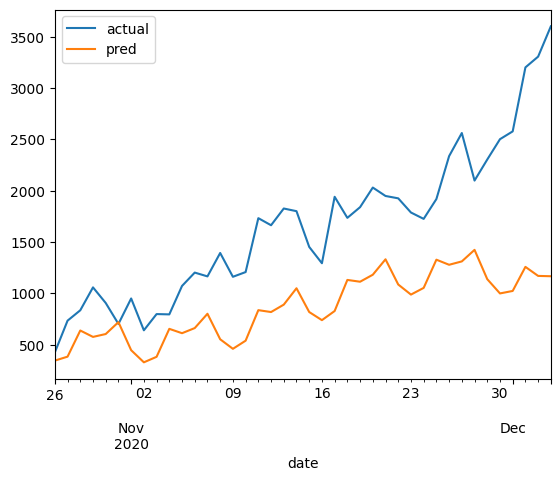

In [ ]:
r2 = r2_score(test.y, forecast_season.tail(40).yhat)
print(r2)

prediction = pd.DataFrame({'actual':test.y.reset_index(drop = True),
              'pred':forecast_season.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [ ]:
train = nyc.iloc[:230, :]
test = nyc.iloc[230:, :]
train = train.ffill()

model_multivariate = Prophet(yearly_seasonality=True, weekly_seasonality=True)

# Add regressor
model_multivariate.add_regressor('stay_at_home_announced', standardize=False)
model_multivariate.fit(train)

In [ ]:
# Create the time range for the forecast
future_multivariate = model_multivariate.make_future_dataframe(periods=40)

# Append the regressor values
future_multivariate = pd.merge(future_multivariate, nyc[['ds', 'stay_at_home_announced']], on='ds', how='inner')

# Fill the missing values with the previous value
future_multivariate = future_multivariate.fillna(method='ffill')

# Check the data
future_multivariate.tail(10)

,ds,stay_at_home_announced
260,2020-11-25,1
261,2020-11-26,1
262,2020-11-27,1
263,2020-11-28,1
264,2020-11-29,1
265,2020-11-30,1
266,2020-12-01,1
267,2020-12-02,1
268,2020-12-03,1
269,2020-12-04,1


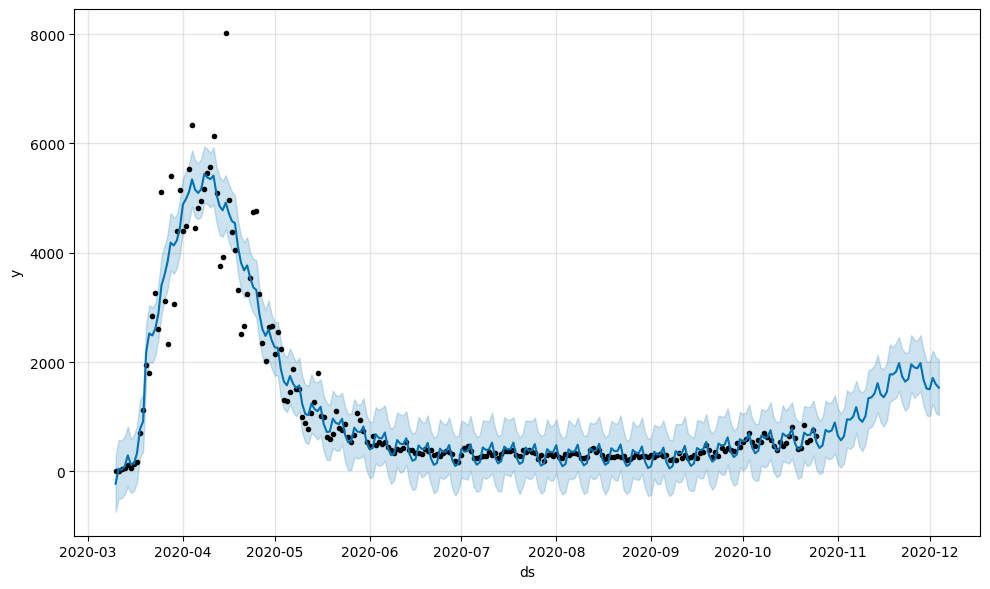

In [ ]:
# Make prediction
forecast_multivariate = model_multivariate.predict(future_multivariate)

# Visualize the forecast
model_multivariate.plot(forecast_multivariate); # Add semi-colon to remove the duplicated chart

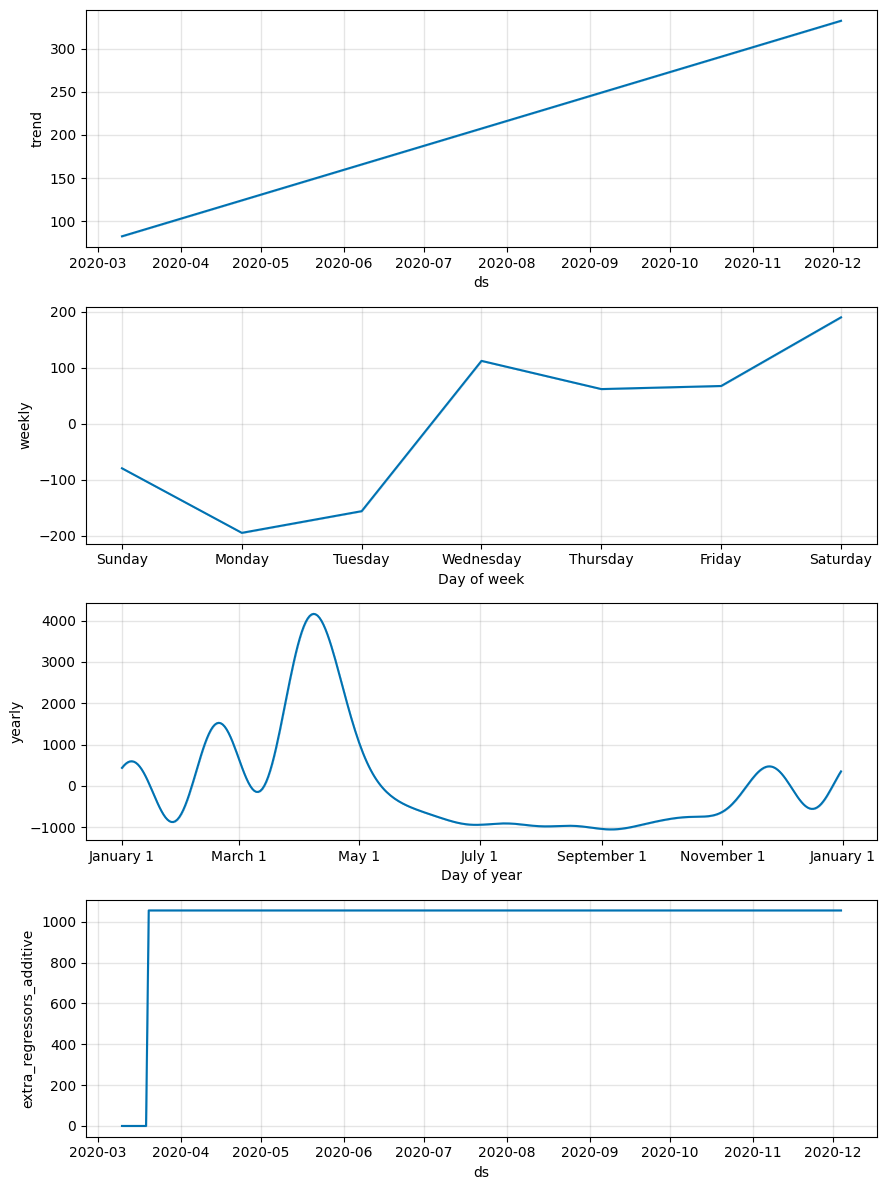

In [ ]:
# Visualize the forecast components
model_multivariate.plot_components(forecast_multivariate);

In [ ]:
# Merge actual and predicted values
performance_multivariate = pd.merge(test, forecast_multivariate[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-40:], on='ds')

# Check MAE value
performance_multivariate_MAE = mean_absolute_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAE for the multivariate model is {performance_multivariate_MAE}')

# Check MAPE value
performance_multivariate_MAPE = mean_absolute_percentage_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAPE for the multivariate model is {performance_multivariate_MAPE}')

The MAE for the multivariate model is 367.4716049196155
The MAPE for the multivariate model is 0.1899817837521515


0.3670070897419624


<Axes: xlabel='date'>

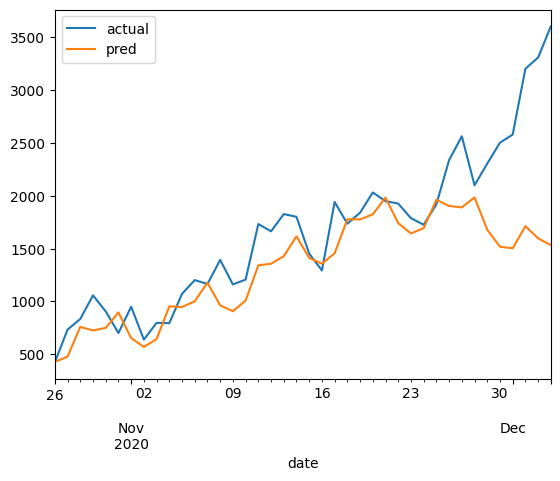

In [ ]:
pred = forecast_multivariate.loc[:, ['ds', 'yhat']][-40:].yhat
r2 = r2_score(test.y, pred)
print(r2)

prediction = pd.DataFrame({'actual':test.y.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test.ds.reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [ ]:
model_multivariate = Prophet(yearly_seasonality=True, weekly_seasonality=True)
model_multivariate.add_regressor('stay_at_home_effective', standardize=False)
model_multivariate.add_regressor('stay_at_home_announced', standardize=False)
model_multivariate.fit(train)
future_multivariate = model_multivariate.make_future_dataframe(periods=40)
future_multivariate = pd.merge(future_multivariate, nyc[['ds', 'stay_at_home_effective', 'stay_at_home_announced']], on='ds', how='inner')
future_multivariate = future_multivariate.fillna(method='ffill')
future_multivariate.tail(10)

,ds,stay_at_home_effective,stay_at_home_announced
260,2020-11-25,1,1
261,2020-11-26,1,1
262,2020-11-27,1,1
263,2020-11-28,1,1
264,2020-11-29,1,1
265,2020-11-30,1,1
266,2020-12-01,1,1
267,2020-12-02,1,1
268,2020-12-03,1,1
269,2020-12-04,1,1


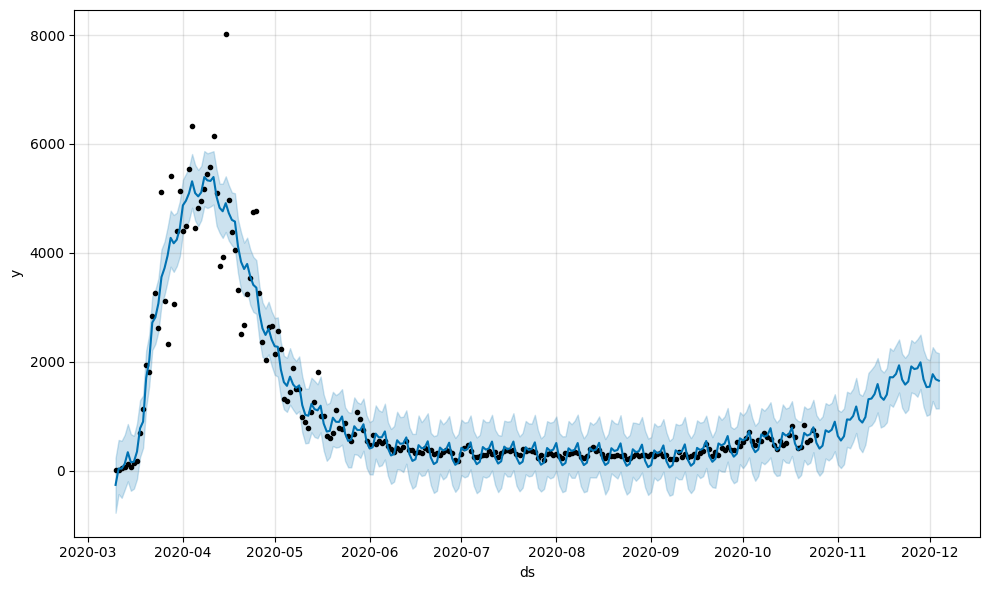

In [ ]:
# Make prediction
forecast_multivariate = model_multivariate.predict(future_multivariate)

# Visualize the forecast
model_multivariate.plot(forecast_multivariate); # Add semi-colon to remove the duplicated chart

In [ ]:
# Merge actual and predicted values
performance_multivariate = pd.merge(test, forecast_multivariate[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-40:], on='ds')

# Check MAE value
performance_multivariate_MAE = mean_absolute_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAE for the multivariate model is {performance_multivariate_MAE}')

# Check MAPE value
performance_multivariate_MAPE = mean_absolute_percentage_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAPE for the multivariate model is {performance_multivariate_MAPE}')

The MAE for the multivariate model is 375.5247849979175
The MAPE for the multivariate model is 0.19904716786635798


0.3966835223758527


<Axes: xlabel='date'>

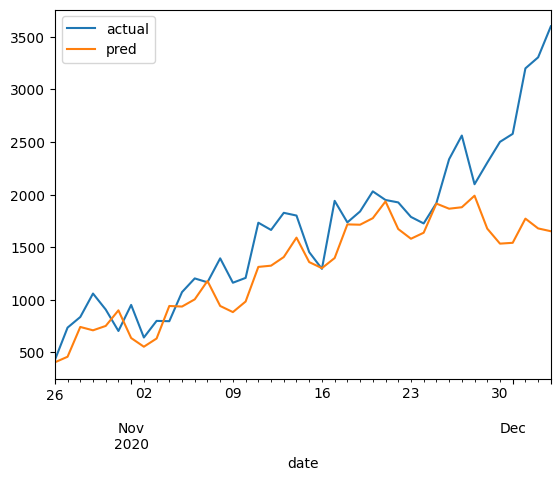

In [ ]:
pred = forecast_multivariate.loc[:, ['ds', 'yhat']][-40:].yhat
r2 = r2_score(test.y, pred)
print(r2)

prediction = pd.DataFrame({'actual':test.y.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test.ds.reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [ ]:
non_static_col = ['stay_at_home_announced', 'stay_at_home_effective', 'mean_temp',
       'min_temp', 'max_temp', 'dewpoint', 'sea_level_pressure', 'visibility',
       'wind_speed', 'max_wind_speed', 'precipitation', 'fog',
       'rain', 'snow', 'hail', 'thunder', 'tornado', 'mean_temp_3d_avg',
       'max_temp_3d_avg', 'min_temp_3d_avg', 'dewpoint_3d_avg']

model_multivariate = Prophet(yearly_seasonality=True, weekly_seasonality=True)
for i in non_static_col:
  model_multivariate.add_regressor(i, standardize=False)
model_multivariate.fit(train)

In [ ]:
non_static_col.append('ds')

In [ ]:
future_multivariate = model_multivariate.make_future_dataframe(periods=40)

# Append the regressor values
future_multivariate = pd.merge(future_multivariate, nyc[non_static_col], on='ds', how='inner')

# Fill the missing values with the previous value
future_multivariate = future_multivariate.fillna(method='ffill')

# Check the data
future_multivariate.tail(10)

,ds,stay_at_home_announced,stay_at_home_effective,mean_temp,min_temp,max_temp,dewpoint,sea_level_pressure,visibility,wind_speed,...,fog,rain,snow,hail,thunder,tornado,mean_temp_3d_avg,max_temp_3d_avg,min_temp_3d_avg,dewpoint_3d_avg
260,2020-11-25,1,1,49.6,42.1,55.0,36.0,1027.8,10.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,51.600000,59.633333,43.700000,39.100000
261,2020-11-26,1,1,58.8,46.9,64.9,51.4,1018.1,9.5,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,54.733333,61.600000,46.700000,44.700000
262,2020-11-27,1,1,55.8,51.1,64.9,46.7,1017.4,10.0,4.4,...,0.0,0.0,0.0,0.0,0.0,0.0,55.800000,64.600000,49.333333,45.700000
263,2020-11-28,1,1,52.8,50.0,64.0,39.0,1015.6,10.0,4.2,...,0.0,0.0,0.0,0.0,0.0,0.0,52.366667,62.633333,48.033333,39.100000
264,2020-11-29,1,1,48.5,43.0,59.0,31.6,1020.4,10.0,4.6,...,0.0,0.0,0.0,0.0,0.0,0.0,52.333333,61.866667,47.666667,39.666667
265,2020-11-30,1,1,55.7,50.0,62.6,48.4,1010.9,8.0,8.4,...,0.0,1.0,0.0,0.0,0.0,0.0,52.400000,61.233333,45.333333,42.066667
266,2020-12-01,1,1,53.0,43.0,62.1,46.2,1001.3,9.8,10.5,...,0.0,1.0,0.0,0.0,0.0,0.0,49.933333,61.233333,43.633333,41.366667
267,2020-12-02,1,1,41.1,37.9,59.0,29.5,1012.9,10.0,15.7,...,0.0,0.0,0.0,0.0,0.0,0.0,45.266667,57.700000,38.966667,34.533333
268,2020-12-03,1,1,41.7,36.0,52.0,27.9,1022.2,10.0,9.8,...,0.0,0.0,0.0,0.0,0.0,0.0,45.266667,57.700000,38.966667,34.533333
269,2020-12-04,1,1,41.7,36.0,52.0,27.9,1022.2,10.0,9.8,...,0.0,0.0,0.0,0.0,0.0,0.0,45.266667,57.700000,38.966667,34.533333


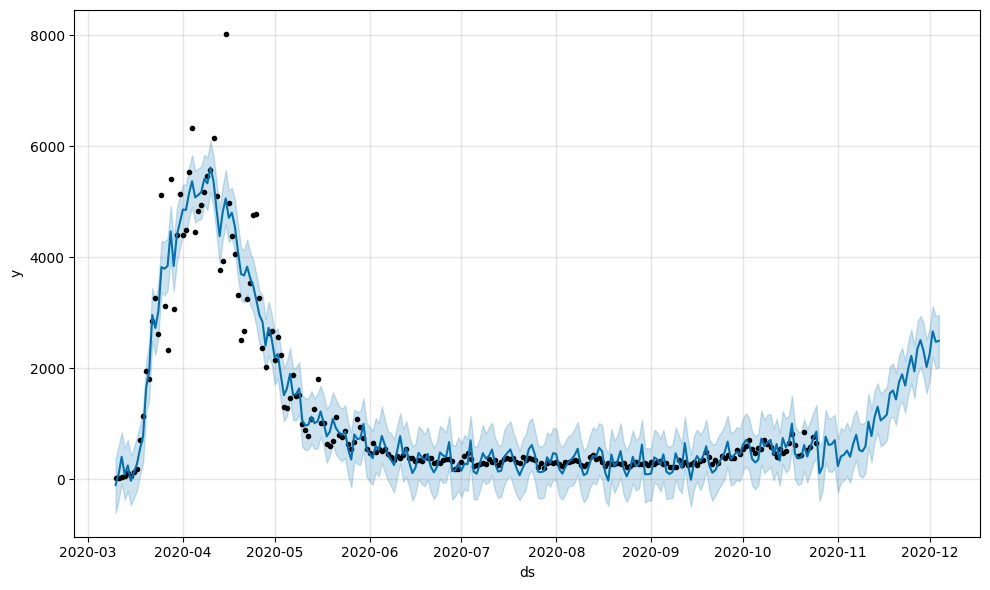

In [ ]:
# Make prediction
forecast_multivariate = model_multivariate.predict(future_multivariate)

# Visualize the forecast
model_multivariate.plot(forecast_multivariate); # Add semi-colon to remove the duplicated chart

In [ ]:
# Merge actual and predicted values
performance_multivariate = pd.merge(test, forecast_multivariate[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-40:], on='ds')

# Check MAE value
performance_multivariate_MAE = mean_absolute_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAE for the multivariate model is {performance_multivariate_MAE}')

# Check MAPE value
performance_multivariate_MAPE = mean_absolute_percentage_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAPE for the multivariate model is {performance_multivariate_MAPE}')

The MAE for the multivariate model is 434.4428561951416
The MAPE for the multivariate model is 0.3064411040431297


0.5365234797667363


<Axes: xlabel='date'>

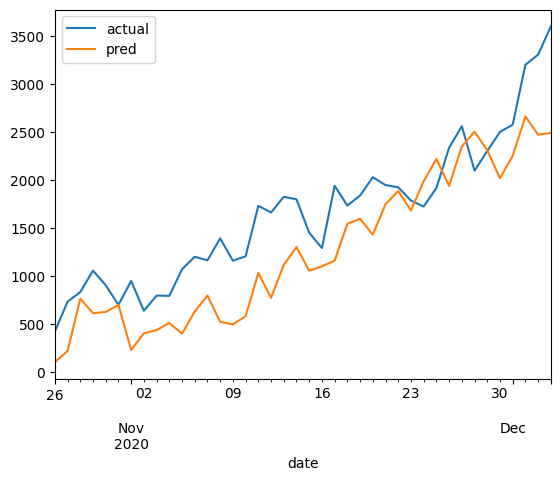

In [ ]:
pred = forecast_multivariate.loc[:, ['ds', 'yhat']][-40:].yhat
r2 = r2_score(test.y, pred)
print(r2)

prediction = pd.DataFrame({'actual':test.y.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test.ds.reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [ ]:
# COVID time window
COVID = pd.DataFrame({
    'holiday': 'COVID',
    'ds': pd.to_datetime(['2020-03-15']),
    'lower_window': -15,
    'upper_window': 15,
})

# Super Bowl time window
superbowl = pd.DataFrame({
    'holiday': 'superbowl',
    'ds': pd.to_datetime(['2020-02-02', '2021-02-07']),
    'lower_window': -7,
    'upper_window': 1,
})

# Combine all events
events = pd.concat((COVID, superbowl))

# Take a look at the events data
events

# Add holidays
model_holiday = Prophet(yearly_seasonality=True, weekly_seasonality=True, holidays=events)

# Add built-in country-specific holidays
model_holiday.add_country_holidays(country_name='US')

# Add regressor
model_holiday.add_regressor('stay_at_home_announced', standardize=False)

# Fit the model on the training dataset
model_holiday.fit(train)

# All the holidays and events
model_holiday.train_holiday_names

0                           COVID
1                       superbowl
2                  New Year's Day
3                    Memorial Day
4                Independence Day
5     Independence Day (observed)
6                       Labor Day
7                    Veterans Day
8                    Thanksgiving
9                   Christmas Day
10     Martin Luther King Jr. Day
11          Washington's Birthday
12                   Columbus Day
dtype: object

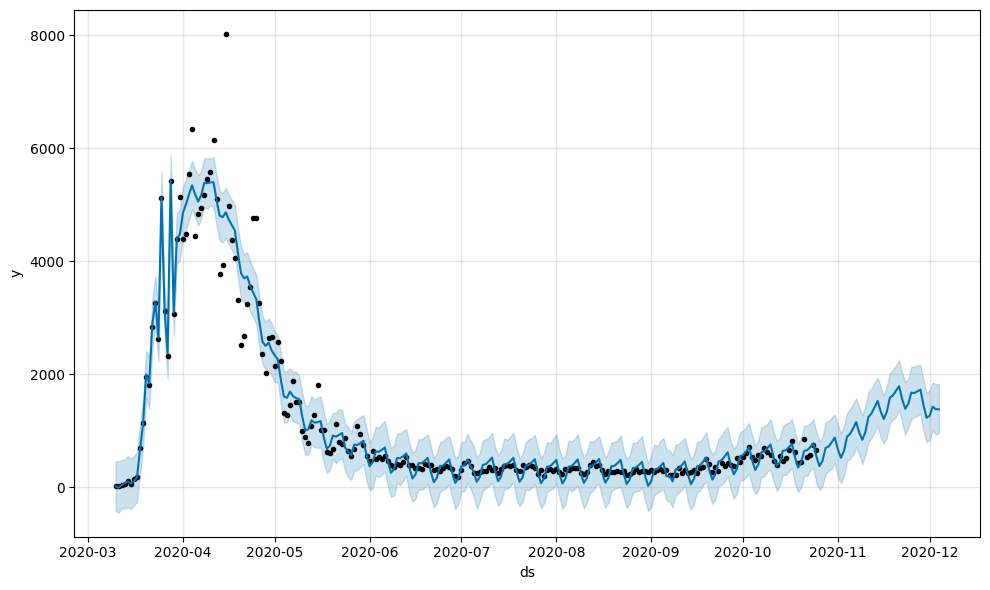

In [ ]:
# Create the time range for the forecast
future_holiday = model_holiday.make_future_dataframe(periods=40)

# Append the regressor values
future_holiday = pd.merge(future_holiday, nyc[['ds', 'stay_at_home_announced']], on='ds', how='inner')

# Fill the missing values with the previous value
future_holiday = future_holiday.fillna(method='ffill')

# Make prediction
forecast_holiday = model_holiday.predict(future_holiday)

# Visualize the forecast
model_holiday.plot(forecast_holiday); # Add semi-colon to remove the duplicated chart

In [ ]:
# Merge actual and predicted values
performance_holiday = pd.merge(test, forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')

# Check MAE value
performance_holiday_MAE = mean_absolute_error(performance_holiday['y'], performance_holiday['yhat'])
print(f'The MAE for the holiday/event model is {performance_holiday_MAE}')

# Check MAPE value
performance_holiday_MAPE = mean_absolute_percentage_error(performance_holiday['y'], performance_holiday['yhat'])
print(f'The MAPE for the holiday/event model is {performance_holiday_MAPE}')

The MAE for the holiday/event model is 828.5121380476444
The MAPE for the holiday/event model is 0.3126717216948625


In [ ]:
# Add seasonality
model_multivariate = Prophet(yearly_seasonality=True, weekly_seasonality=True)

# Add regressor
model_multivariate.add_regressor('max_temp', standardize=False)

# Fit the model on the training dataset
model_multivariate.fit(nyc)

ValueError: Found NaN in column 'max_temp'

In [ ]:


# Assuming you have a DataFrame 'df' with timestamp, target variable, and related variables
# df = ...

# Separate target variable and related variables
target_variable = df[['timestamp', 'target_variable']]
related_variable_1 = df[['timestamp', 'related_variable_1']]
related_variable_2 = df[['timestamp', 'related_variable_2']]

# Prepare target variable DataFrame
target_variable.columns = ['ds', 'y']

# Create and fit Prophet model for target variable
model_target_variable = Prophet()
model_target_variable.fit(target_variable)

# Prepare related variable DataFrames
related_variable_1.columns = ['ds', 'y']
related_variable_2.columns = ['ds', 'y']

# Create and fit Prophet models for related variables
model_related_variable_1 = Prophet()
model_related_variable_1.fit(related_variable_1)

model_related_variable_2 = Prophet()
model_related_variable_2.fit(related_variable_2)

# Make forecasts
future_target_variable = model_target_variable.make_future_dataframe(periods=30)
forecast_target_variable = model_target_variable.predict(future_target_variable)

future_related_variable_1 = model_related_variable_1.make_future_dataframe(periods=30)
forecast_related_variable_1 = model_related_variable_1.predict(future_related_variable_1)

future_related_variable_2 = model_related_variable_2.make_future_dataframe(periods=30)
forecast_related_variable_2 = model_related_variable_2.predict(future_related_variable_2)

# Further processing and integration of forecasts as needed
